In [ ]:
# run this cell, then restart kernel
!pip install -qq botocore --upgrade --user
!pip install -qq boto3 --upgrade --user
!pip install -qq awscli --upgrade --user

In [1]:
# run this cell after restarting kernel
!pip install -qq sagemaker --upgrade
!pip install -qq torch --upgrade
!pip install -qq sagemaker-huggingface-inference-toolkit 
!pip install -qq transformers "datasets[s3]"
!pip install -qq ipywidgets
!pip install -qq watermark 
!pip install -qq seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.
spacy 3.0.6 requires pydantic<1.8.0,>=1.7.1, but you have pydantic 1.8.2 which is incompatible.


In [2]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs
import sagemaker.huggingface
from sagemaker.huggingface import HuggingFace
import transformers
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, load_dataset, load_dataset_builder, load_metric

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from textwrap import wrap

import boto3
import pprint
import time

In [3]:
# set up sagemaker session
sess = sagemaker.Session()
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::524579011464:role/SageMakerExecutionRole
sagemaker bucket: sagemaker-us-east-1-524579011464
sagemaker session region: us-east-1


# Finetune RoBERTa to predict virality scores

In [10]:
# create RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# load data
data_path = "./data"
train_path = data_path + "/train_tweets.csv"
data = load_dataset("csv", data_files=train_path) #, features=features)
data = data['train']

Using custom data configuration default-8e44d270b3058d87
Reusing dataset csv (/home/ec2-user/.cache/huggingface/datasets/csv/default-8e44d270b3058d87/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['Text'], truncation=True)

In [12]:
# assign virality score to labels column
virality_score_label = "ViralityScoreSimple_NormalizedByUserMedian"
def assign_virality_label(example):
    example["labels"] = example[virality_score_label]
    return example

In [13]:
# assign viral (1) vs. not viral (0) labels
labeled_data = data.map(assign_virality_label)

# tokenize data
tokenized_data = labeled_data.map(tokenize, batched=True)

test_size = 0.2

'''
# FOR PROTOTYPING: only use first 1000 examples
proto_tokenized_data = tokenized_data.shuffle(seed=42).select(range(1000))
proto_split_data = proto_tokenized_data.train_test_split(test_size=test_size, shuffle=True)
# get training set
proto_train_data = proto_split_data['train']
# split again into validation and test sets
proto_valid_test_data = proto_split_data['test'].train_test_split(test_size=0.5)
# get validation set
proto_valid_data = proto_valid_test_data['train']
# get test set
proto_test_data = proto_valid_test_data['test']
'''

# split data into train and test sets
split_data = tokenized_data.train_test_split(test_size=test_size, shuffle=True)
# get training set
train_data = split_data['train']
# split again into validation and test sets
valid_test_data = split_data['test'].train_test_split(test_size=0.5)
# get validation set
valid_data = valid_test_data['train']
# get test set
test_data = valid_test_data['test']

Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/csv/default-8e44d270b3058d87/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-93b2a57986bc708f.arrow
Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/csv/default-8e44d270b3058d87/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-805736eaf65c79a3.arrow


In [14]:
# format train data to pytorch
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
#proto_train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
metric = load_metric("mse")

learning_rates = [5e-6, 1e-5, 2e-5, 5e-5]
errors = []
strategy = "epoch"

# training loop to optimize learning rate and epochs
for lr in learning_rates:
    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=1) 
    model.to(torch.device("cuda"))
    
    training_args = TrainingArguments(
        output_dir="test_trainer", 
        evaluation_strategy=strategy,
        save_strategy=strategy,
        logging_strategy=strategy,
        num_train_epochs=4,
        learning_rate=lr,
        load_best_model_at_end=True
    )
    
    trainer = Trainer(
        model = model,
        args = training_args,
        train_dataset = train_data,
        eval_dataset = valid_data,
        compute_metrics = compute_metrics,
        tokenizer = tokenizer 
    )
        
    trainer.train()
    
    prediction = trainer.predict(test_data)
    test_mse = prediction.metrics['test_mse']
    errors.append(test_mse)
    
    model_name = "./test_trainer/model_" + virality_score_label + "_lr={lr:.0e}_mse={mse:.2f}".format(lr=lr, mse=test_mse)
    trainer.save_model(model_name)
    
    # remove test trainer checkpoint files
    !rm RoBERTa/test_trainer/checkpoint* -r
    
# plot mse vs learning rate
plt.plot(learning_rates, errors)
plt.title(virality_score_label + " Test MSE vs. Learning Rate")
plt.xlabel("learning rate")
plt.ylabel("test MSE")
plt.savefig(virality_score_label + "lr_mse.png")

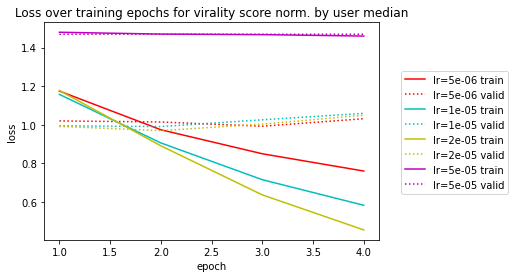

In [9]:
# ViralityScoreSimple_NormalizedByTotalMedian
'''
learning_rates = [1e-5, 2e-5, 5e-5, 7.5e-5]
train_loss = [
    [1.715500, 1.228800, 0.928500, 0.736600],
    [1.747900, 1.203900, 0.839400, 0.589900],
    [1.933000, 1.410100, 1.011000, 0.671400],
    [2.499100, 2.488200, 2.478800, 2.472800]
]
valid_loss = [
    [1.510489, 1.409851, 1.378049, 1.414043],
    [1.525817, 1.356487, 1.363454, 1.402772],
    [1.673826, 1.530528, 1.436984, 1.508058],
    [2.532647, 2.521519, 2.522391, 2.521056]
]
'''

# ViralityScore_NormalizedByTotalMedian
'''
learning_rates = [5e-6, 1e-5, 2e-5, 5e-5]
train_loss = [
    [5.450600, 4.203500, 3.504400, 3.049300],
    [5.726000, 4.355900, 3.087100, 2.049400],
    [5.323100, 3.690800, 2.531000, 1.768400],
    [5.291800, 3.827100, 2.880200, 2.262100]
]

valid_loss = [
    [4.612507, 4.545609, 4.314688, 4.399825],
    [4.887200, 5.360254, 4.226186, 4.526827],
    [4.468752, 3.904405, 4.267315, 4.452236],
    [4.407519, 3.944263, 4.117460, 4.215764]
]
'''

# ViralityScoreSimple_NormalizedByUserMedian
'''
learning_rates = [5e-6, 1e-5, 2e-5, 5e-5]
train_loss = [
    [1.112900, 0.924700, 0.801000, 0.724600],
    [1.107500, 0.872100, 0.687500, 0.558400],
    [1.122800, 0.867100, 0.631600, 0.462400],
    [1.419700, 1.435200, 1.431000, 1.424700]
]
valid_loss = [
    [0.984366, 1.005421, 0.964301, 0.999405],
    [0.976736, 0.989782, 0.984413, 1.027293],
    [0.985014, 0.965548, 0.974290, 1.044437],
    [1.357621, 1.361440, 1.355929, 1.355403]
]
'''

# ViralityScore_NormalizedByUserMedian
learning_rates = [5e-6, 1e-5, 2e-5, 5e-5]
train_loss = [
    [1.174900, 0.974600, 0.850300, 0.760900],
    [1.157500, 0.906400, 0.716000, 0.583700],
    [1.177500, 0.891400, 0.637400, 0.456100],
    [1.479400, 1.469800, 1.467100, 1.459600]
]
valid_loss = [
    [1.020328, 1.014788, 0.992721, 1.031842],
    [0.995074, 0.991157, 1.026172, 1.059588],
    [0.992120, 0.970083, 1.003705, 1.049842],
    [1.469030, 1.469516, 1.468846, 1.469292]
]

epochs = [1, 2, 3, 4]
colors = ['r', 'c', 'y', 'm']

fig = plt.figure(1)
for i in range(4):
    lr = learning_rates[i]
    color = colors[i]
    plt.plot(epochs, train_loss[i], linestyle='-', color=color, label="lr={:.0e} train".format(lr))
    plt.plot(epochs, valid_loss[i], linestyle=':', color=color, label="lr={:.0e} valid".format(lr))

plt.legend(bbox_to_anchor=(1.05,0.8))
plt.title("Loss over training epochs for virality score norm. by user median")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()
fig.savefig("./virality_pred_fig/" + virality_score_label + "_training_loss".format(lr), bbox_inches='tight')

# Predict virality scores of tweets generated by GPT-2

In [16]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

metric = load_metric("mse")
strategy = "epoch"

# load best model
best_model_filename = "./test_trainer/model_ViralityScoreSimple_NormalizedByUserMedian_lr=2e-05_mse=1.02"
model = RobertaForSequenceClassification.from_pretrained(best_model_filename)
model.to(torch.device("cuda"))

training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy=strategy,
    save_strategy=strategy,
    logging_strategy=strategy,
    num_train_epochs=3,
    learning_rate=2e-5,
    load_best_model_at_end=True
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = valid_data,
    compute_metrics = compute_metrics,
    tokenizer = tokenizer 
)

In [17]:
dem_nonviral_twts_file = "./data/dem_nonviral.txt"
dem_viral_twts_file = "./data/dem_viral.txt"
rep_nonviral_twts_file = "./data/rep_nonviral.txt"
rep_viral_twts_file = "./data/rep_viral.txt"
gen_data_folder = "./gen_data/"

In [22]:
import re
# clean up gpt generated tweets

with open(dem_nonviral_twts_file, 'r') as file:
    text = file.read()
    text = text.replace("<BOS>", "")
    text = text.replace("<|endoftext|>", "")
    text = re.split(r'=== GENERATED SEQUENCE [0-9]{1,3} ===', text)
    dem_nonviral_twts = text[1:]
for i in range(len(dem_nonviral_twts)):
    dem_nonviral_twts[i] = dem_nonviral_twts[i].strip()
    
with open(dem_viral_twts_file, 'r') as file:
    text = file.read()
    text = text.replace("<BOS>", "")
    text = text.replace("<|endoftext|>", "")
    text = re.split(r'=== GENERATED SEQUENCE [0-9]{1,3} ===', text)
    dem_viral_twts = text[1:]
for i in range(len(dem_viral_twts)):
    dem_viral_twts[i] = dem_viral_twts[i].strip()
    
with open(rep_nonviral_twts_file, 'r') as file:
    text = file.read()
    text = text.replace("<BOS>", "")
    text = text.replace("<|endoftext|>", "")
    text = re.split(r'=== GENERATED SEQUENCE [0-9]{1,3} ===', text)
    rep_nonviral_twts = text[1:]
for i in range(len(rep_nonviral_twts)):
    rep_nonviral_twts[i] = rep_nonviral_twts[i].strip()
    
with open(rep_viral_twts_file, 'r') as file:
    text = file.read()
    text = text.replace("<BOS>", "")
    text = text.replace("<|endoftext|>", "")
    text = re.split(r'=== GENERATED SEQUENCE [0-9]{1,3} ===', text)
    rep_viral_twts = text[1:]
for i in range(len(rep_viral_twts)):
    rep_viral_twts[i] = rep_viral_twts[i].strip()

In [23]:
dem_nonviral_df = pd.DataFrame()
dem_nonviral_df.insert(0, "Text", dem_nonviral_twts)
dem_nonviral_data = Dataset.from_pandas(dem_nonviral_df)

dem_viral_df = pd.DataFrame()
dem_viral_df.insert(0, "Text", dem_viral_twts)
dem_viral_data = Dataset.from_pandas(dem_viral_df)

rep_nonviral_df = pd.DataFrame()
rep_nonviral_df.insert(0, "Text", rep_nonviral_twts)
rep_nonviral_data = Dataset.from_pandas(rep_nonviral_df)

rep_viral_df = pd.DataFrame()
rep_viral_df.insert(0, "Text", rep_viral_twts)
rep_viral_data = Dataset.from_pandas(rep_viral_df)

In [24]:
tokenized_dem_nonviral_data = dem_nonviral_data.map(tokenize, batched=True)
tokenized_dem_viral_data = dem_viral_data.map(tokenize, batched=True)
tokenized_rep_nonviral_data = rep_nonviral_data.map(tokenize, batched=True)
tokenized_rep_viral_data = rep_viral_data.map(tokenize, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [25]:
# compute virality score predictions
dem_nonviral_preds = trainer.predict(tokenized_dem_nonviral_data)
dem_viral_preds = trainer.predict(tokenized_dem_viral_data)
rep_nonviral_preds = trainer.predict(tokenized_rep_nonviral_data)
rep_viral_preds = trainer.predict(tokenized_rep_viral_data)

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 100
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 100
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 100
  Batch size = 8
The following co

In [26]:
# save predicted scores
from numpy import savetxt
savetxt(gen_data_folder + 'dem_nonviral_preds.txt', dem_nonviral_preds.predictions)
savetxt(gen_data_folder + 'dem_viral_preds.txt', dem_viral_preds.predictions)
savetxt(gen_data_folder + 'rep_nonviral_preds.txt', rep_nonviral_preds.predictions)
savetxt(gen_data_folder + 'rep_viral_preds.txt', rep_viral_preds.predictions)

In [27]:
dem_nonviral_avg = np.mean(dem_nonviral_preds.predictions)
dem_viral_avg = np.mean(dem_viral_preds.predictions)
dem_nonviral_med = np.median(dem_nonviral_preds.predictions)
dem_viral_med = np.median(dem_viral_preds.predictions)
print("dem mean:", dem_nonviral_avg, dem_viral_avg)
print("dem median:", dem_nonviral_med, dem_viral_med)

rep_nonviral_avg = np.mean(rep_nonviral_preds.predictions)
rep_viral_avg = np.mean(rep_viral_preds.predictions)
rep_nonviral_med = np.median(rep_nonviral_preds.predictions)
rep_viral_med = np.median(rep_viral_preds.predictions)
print("rep mean:", rep_nonviral_avg, rep_viral_avg)
print("rep median:", rep_nonviral_med, rep_viral_med)

dem mean: -0.8178626 0.11799254
dem median: -0.9169251 0.22852448
rep mean: -0.8549225 -0.015804315
rep median: -0.80677074 0.1156112


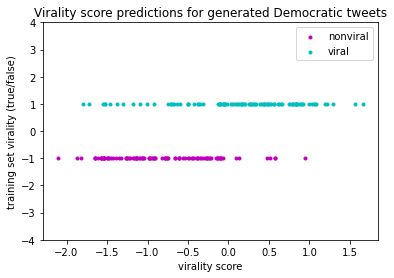

In [28]:
# plot scores for democratic tweets
fig = plt.figure(1)
plt.scatter(dem_nonviral_preds.predictions, np.repeat(-1,100), color='m', marker='.', label="nonviral")
plt.scatter(dem_viral_preds.predictions, np.repeat(1,100), color='c', marker='.', label="viral")
plt.legend()
plt.ylim([-4,4])
plt.title("Virality score predictions for generated Democratic tweets")
plt.xlabel("virality score")
plt.ylabel("training set virality (true/false)")
fig.savefig(gen_data_folder + "dem_tweets_bool.png", bbox_inches='tight')

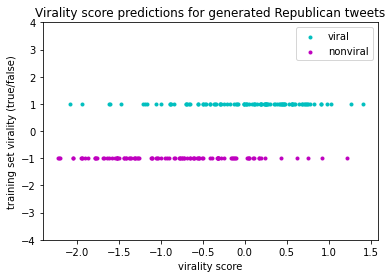

In [30]:
# plot scores for republican tweets
fig = plt.figure(1)
plt.scatter(rep_viral_preds.predictions, np.repeat(1,100), color='c', marker='.', label="viral")
plt.scatter(rep_nonviral_preds.predictions, np.repeat(-1,100), color='m', marker='.', label="nonviral")
plt.legend()
plt.ylim([-4,4])
plt.title("Virality score predictions for generated Republican tweets")
plt.xlabel("virality score")
plt.ylabel("training set virality (true/false)")
fig.savefig(gen_data_folder + "rep_tweets_bool.png", bbox_inches='tight')

In [31]:
# get top 10 most viral and bottom 10 least viral tweets for each party
top_10_viral_dem = np.argsort(np.reshape(dem_viral_preds.predictions, -1))[::-1][:10]
bot_10_viral_dem = np.argsort(np.reshape(dem_nonviral_preds.predictions, -1))[:10]
top_10_viral_rep = np.argsort(np.reshape(rep_viral_preds.predictions, -1))[::-1][:10]
bot_10_viral_rep = np.argsort(np.reshape(rep_nonviral_preds.predictions, -1))[:10]

In [32]:
top_10_viral_dem_twts = [None] * 10
bot_10_viral_dem_twts = [None] * 10
top_10_viral_rep_twts = [None] * 10
bot_10_viral_rep_twts = [None] * 10

for i in range(10):
    top_10_viral_dem_twts[i] = dem_viral_twts[top_10_viral_dem[i]]
    bot_10_viral_dem_twts[i] = dem_nonviral_twts[bot_10_viral_dem[i]]
    top_10_viral_rep_twts[i] = rep_viral_twts[top_10_viral_rep[i]]
    bot_10_viral_rep_twts[i] = rep_nonviral_twts[bot_10_viral_rep[i]]

In [33]:
# save tweets
with open(gen_data_folder + 'top_dem_twts.txt', 'w') as f:
    for tweet in top_10_viral_dem_twts:
        f.write("%s\n\n" % tweet)
        
with open(gen_data_folder + 'bot_dem_twts.txt', 'w') as f:
    for tweet in bot_10_viral_dem_twts:
        f.write("%s\n\n" % tweet)
        
with open(gen_data_folder + 'top_rep_twts.txt', 'w') as f:
    for tweet in top_10_viral_rep_twts:
        f.write("%s\n\n" % tweet)
        
with open(gen_data_folder + 'bot_rep_twts.txt', 'w') as f:
    for tweet in bot_10_viral_rep_twts:
        f.write("%s\n\n" % tweet)

# Finetune RoBERTa to classify party affiliation

In [34]:
def assign_party_label(example):
    # 0 = democrat, 1 = republican
    example["labels"] = int(example["Party"] == "republican")
    return example

In [35]:
def compute_party_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return party_metric.compute(predictions=predictions, references=labels)

In [36]:
# assign party labels
labeled_party_data = data.map(assign_party_label)

# tokenize data
tokenized_party_data = labeled_party_data.map(tokenize, batched=True)

# split data into train and test sets
split_party_data = tokenized_party_data.train_test_split(test_size=test_size, shuffle=True)
# get training set
train_party_data = split_party_data['train']
# split again into validation and test sets
valid_test_party_data = split_party_data['test'].train_test_split(test_size=0.5)
# get validation set
valid_party_data = valid_test_party_data['train']
# get test set
test_party_data = valid_test_party_data['test']

  0%|          | 0/25526 [00:00<?, ?ex/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

In [37]:
train_party_data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
party_metric = load_metric("f1")

lr = 2e-5
strategy = "epoch"

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2) 
model.to(torch.device("cuda"))

training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy=strategy,
    save_strategy=strategy,
    logging_strategy=strategy,
    num_train_epochs=4,
    learning_rate=lr,
    load_best_model_at_end=True
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_party_data,
    eval_dataset = valid_party_data,
    compute_metrics = compute_party_metrics,
    tokenizer = tokenizer 
)

trainer.train()

In [ ]:
prediction = trainer.predict(test_party_data)
test_f1 = prediction.metrics['test_f1']

model_name = "./test_trainer/model_party_lr={lr:.0e}_f1={f1:.2f}".format(lr=lr, f1=test_f1)
trainer.save_model(model_name)

# Predict party affiliation for tweets generated by GPT-2

In [39]:
metric = load_metric("f1")
strategy = "epoch"

# load best model
best_party_model_filename = "./test_trainer/model_party_lr=2e-05_f1=0.90"
model = RobertaForSequenceClassification.from_pretrained(best_party_model_filename)
model.to(torch.device("cuda"))

training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy=strategy,
    save_strategy=strategy,
    logging_strategy=strategy,
    num_train_epochs=1,
    learning_rate=2e-5,
    load_best_model_at_end=True
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_party_data,
    eval_dataset = valid_party_data,
    compute_metrics = compute_party_metrics,
    tokenizer = tokenizer 
)

loading configuration file ./test_trainer/model_party_lr=2e-05_f1=0.90/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./test_trainer/model_party_lr=2e-05_f1=0.90/pytorch_model.bin
All model checkpoint weights were used when initializing RobertaForSequ

In [40]:
def convert_logits_to_class(logits):
    return np.argmax(logits)

In [41]:
# predict party affiliations
dem_nonviral_party_preds = trainer.predict(tokenized_dem_nonviral_data).predictions
dem_viral_party_preds = trainer.predict(tokenized_dem_viral_data).predictions
rep_nonviral_party_preds = trainer.predict(tokenized_rep_nonviral_data).predictions
rep_viral_party_preds = trainer.predict(tokenized_rep_viral_data).predictions

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 100
  Batch size = 8


The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 100
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 100
  Batch size = 8
The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Text. If Text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 100
  Batch size = 8


In [42]:
dem_nonviral_party_class = np.apply_along_axis(convert_logits_to_class, 1, np.array(dem_nonviral_party_preds))
dem_viral_party_class = np.apply_along_axis(convert_logits_to_class, 1, np.array(dem_viral_party_preds))
rep_nonviral_party_class = np.apply_along_axis(convert_logits_to_class, 1, np.array(rep_nonviral_party_preds))
rep_viral_party_class = np.apply_along_axis(convert_logits_to_class, 1, np.array(rep_viral_party_preds))

In [43]:
# save party predictions
from numpy import savetxt
savetxt(gen_data_folder + 'dem_nonviral_party_preds.txt', dem_nonviral_party_class)
savetxt(gen_data_folder + 'dem_viral_party_preds.txt', dem_viral_party_class)
savetxt(gen_data_folder + 'rep_nonviral_party_preds.txt', rep_nonviral_party_class)
savetxt(gen_data_folder + 'rep_viral_party_preds.txt', rep_viral_party_class)

In [44]:
# calculate f1 of predictions for generated tweets

dem_viral_tp = 0
dem_viral_fp = np.sum(dem_viral_party_class == 1)
dem_viral_tn = np.sum(dem_viral_party_class == 0)
dem_viral_fn = 0

dem_nonviral_tp = 0
dem_nonviral_fp = np.sum(dem_nonviral_party_class == 1)
dem_nonviral_tn = np.sum(dem_nonviral_party_class == 0)
dem_nonviral_fn = 0

rep_viral_tp = np.sum(rep_viral_party_class == 1)
rep_viral_fp = 0
rep_viral_tn = 0
rep_viral_fn = np.sum(rep_viral_party_class == 0)

rep_nonviral_tp = np.sum(rep_nonviral_party_class == 1)
rep_nonviral_fp = 0
rep_nonviral_tn = 0
rep_nonviral_fn = np.sum(rep_nonviral_party_class == 0)

tp = dem_viral_tp + dem_nonviral_tp + rep_viral_tp + rep_nonviral_tp
fp = dem_viral_fp + dem_nonviral_fp + rep_viral_fp + rep_nonviral_fp
tn = dem_viral_tn + dem_nonviral_tn + rep_viral_tn + rep_nonviral_tn
fn = dem_viral_fn + dem_nonviral_fn + rep_viral_fn + rep_nonviral_fn

# recall = true positive / (true positive + false negative)
recall = tp / (tp + fn)
# precision = true positive / (true positive + false positive)
precision = tp / (tp + fp)
f1 = 2 / (1 / recall + 1 / precision)

In [45]:
print(tp, fp, tn, fn, f1)

150 39 161 50 0.7712082262210798
